## Travel time analysis

Notebook to analyse the travel time per road

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

### Data reading

In [4]:
# Read in travel time results and SourceSink data
scenarios = range(0,5)
results = {}
for s in scenarios:
    results[s] = pd.read_csv(f"../experiments/results_scenario_{s}.csv", index_col=0)
    results[s].drop("VehicleID", axis="columns", inplace=True)
source_sinks = pd.read_csv(f"../experiments/source_data.csv", index_col=0)

In [5]:
results[2].head()

,Travel_Time,Startpoint,Endpoint
0,31,SourceSink13012,13040
1,9,SourceSink13012,13022
2,31,SourceSink13040,13012
3,24,SourceSink13023,13034
4,13,SourceSink13012,13033


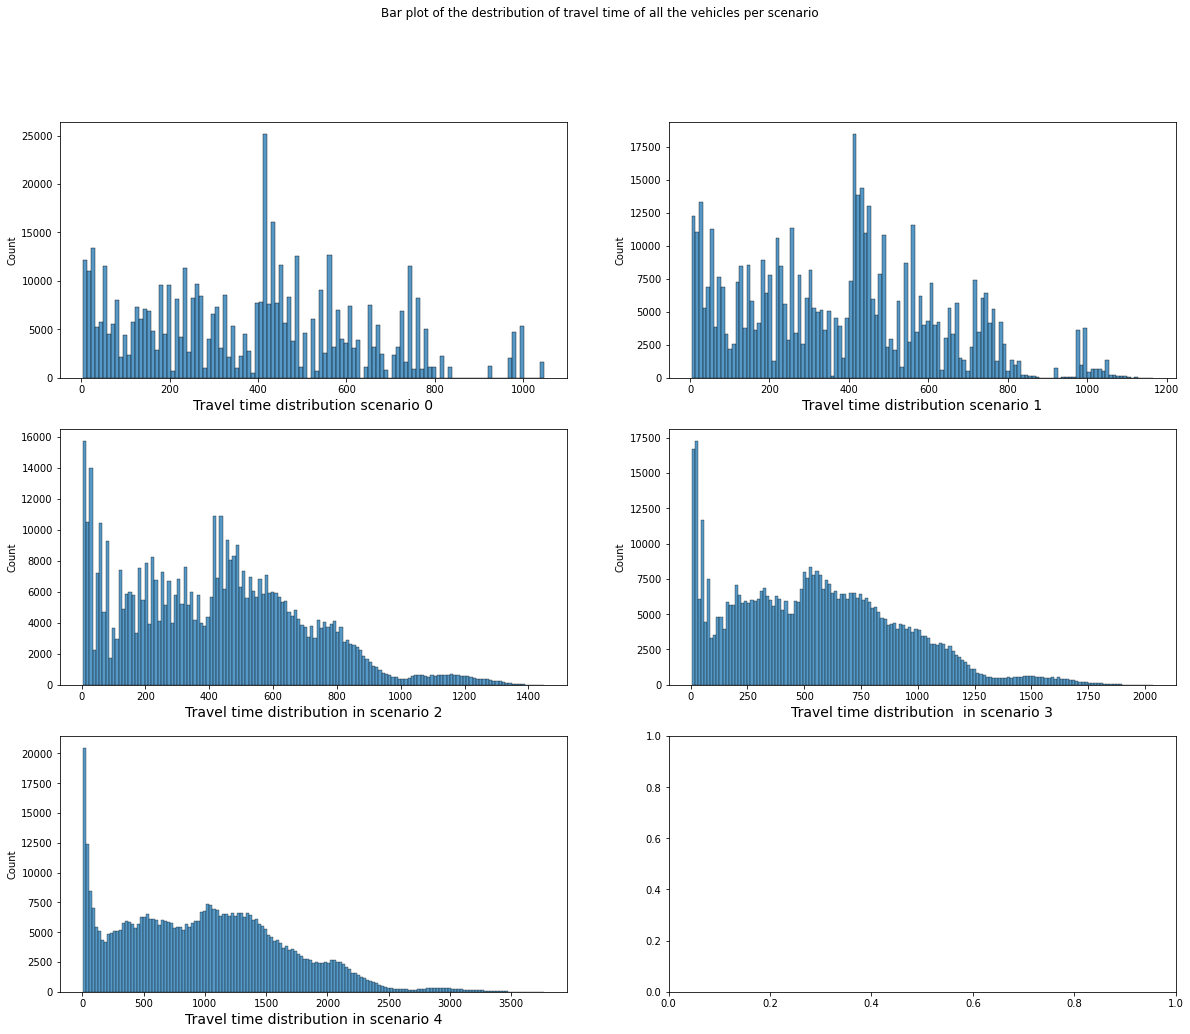

In [6]:
# visualisation of the deviation of the time taken (in minutes) for each scenario
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 16))
fig.suptitle('Bar plot of the destribution of travel time of all the vehicles per scenario')

sns.histplot(ax=axs[0,0], data=results[0]['Travel_Time'])
axs[0,0].set_xlabel('Travel time distribution scenario 0', fontsize=14)

sns.histplot(ax=axs[0,1], data=results[1]['Travel_Time'])
axs[0,1].set_xlabel('Travel time distribution scenario 1', fontsize=14)

sns.histplot(ax=axs[1,0], data=results[2]['Travel_Time'])
axs[1,0].set_xlabel('Travel time distribution in scenario 2', fontsize=14)

sns.histplot(ax=axs[1,1], data=results[3]['Travel_Time'])
axs[1,1].set_xlabel('Travel time distribution  in scenario 3', fontsize=14)

sns.histplot(ax=axs[2,0], data=results[4]['Travel_Time'])
axs[2,0].set_xlabel('Travel time distribution in scenario 4', fontsize=14)

plt.savefig('../img/histograme.png')


KeyboardInterrupt



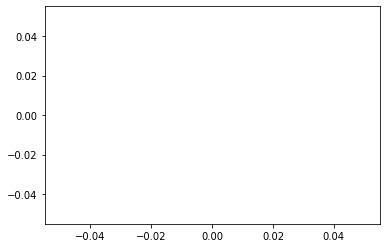

In [7]:
sns.lineplot(data=results[1]['Travel_Time'])

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 16))
fig.suptitle('Bar plot of the destribution of travel time of all the vehicles per scenario')

sns.boxplot(ax=axs[0,0], data=results[0]['Travel_Time'])
axs[0,0].set_xlabel('Travel time distribution scenario 0', fontsize=14)

sns.boxplot(ax=axs[0,1], data=results[1]['Travel_Time'])
axs[0,1].set_xlabel('Travel time distribution scenario 1', fontsize=14)

sns.boxplot(ax=axs[1,0], data=results[2]['Travel_Time'])
axs[1,0].set_xlabel('Travel time distribution in scenario 2', fontsize=14)

sns.boxplot(ax=axs[1,1], data=results[3]['Travel_Time'])
axs[1,1].set_xlabel('Travel time distribution  in scenario 3', fontsize=14)

sns.boxplot(ax=axs[2,0], data=results[4]['Travel_Time'])
axs[2,0].set_xlabel('Travel time distribution in scenario 4', fontsize=14)

plt.show()

#### Create human readable labels for sourcesinks

In [ ]:
# Split the coordinates in latitude and longitude
source_sinks["lat"] = source_sinks["Coordinates"].apply(lambda x: float(x.split(',')[1].replace(')', '')))
source_sinks["lon"] = source_sinks["Coordinates"].apply(lambda x: float(x.split(',')[0].replace('(', '')))

# Create lists of roads, dictionary for north south and east west
road_list = source_sinks["Road"].unique().tolist()
sources_NS = {}
sources_WE = {}

# Check which sourcesink the the northmost etc. for each road
for road in road_list:
    df = source_sinks.loc[source_sinks["Road"] == road]
    sources_NS[df.loc[df['lat'].idxmax()].name]  = "North"
    sources_NS[df.loc[df['lat'].idxmin()].name]  = "South"
    sources_WE[df.loc[df['lon'].idxmax()].name]  = "East"
    sources_WE[df.loc[df['lon'].idxmin()].name]  = "West"

# Add values to dataframe and create labels
source_sinks["NS"] = pd.Series(sources_NS)
source_sinks["WE"] = pd.Series(sources_WE)
source_sinks["Label"] = source_sinks["Road"] + '_' + source_sinks["NS"] + source_sinks["WE"]

# Create dictionary with labels and print dataframe head
s_name_dict = source_sinks["Label"].to_dict()
source_sinks.head(5)

### Global average travel time

In [ ]:
#calculating 95% confidence intervals of the economic losses
confidence = 0.95

average = {}
low_bound = {}
high_bound = {}
interval_range = {}
economic_interval = {}

for i in scenarios:
    results_list = results[i]["Travel_Time"].tolist()
    average[i] = np.mean(results_list)
    low_bound[i], high_bound[i] = st.norm.interval(alpha=confidence, loc=average[i], scale=st.sem(results_list))
    interval_range[i] = high_bound[i] - low_bound[i]
    economic_interval[i] = interval_range[i] / average[i] * 100

    print(f'Average travel time (95% confidence interval) for scenario {i}: {average[i]:.3f} ({low_bound[i]:.3f}, {high_bound[i]:.3f}), economic interval: {economic_interval[i]:.3f}%')

df = pd.DataFrame({
    "Average (min)": average,
    "Low bound (min)": low_bound,
    "High bound (min)": high_bound,
    "Interval range (min)": interval_range,
    "Economic interval (%)": economic_interval})
df.to_csv("../results/travel_times.csv", index_label="Scenario")
df

### Average travel time per route

In [ ]:
# Test for getting average travel time between two points
df = results[3]
dfi = df.loc[df['Startpoint'] == f'SourceSink{11303}']
dfi2 = dfi.loc[dfi['Endpoint'] == 12800]
dfi2["Travel_Time"].mean()

In [ ]:
# Create lists of start and end points
start_points = set([int(i.replace('SourceSink', '')) for i in results[2]["Startpoint"].tolist()])
end_points = set(results[2]["Endpoint"].tolist())

In [ ]:
# For all scenarios, for all startpoints (sources) and for all endpoints (sinks), report the average travel time.
tt_roads = {}
for s, df in results.items():
    tt_roads[s] = {}
    for sp in start_points:
        dfi = df.loc[df['Startpoint'] == f'SourceSink{sp}']
        sp_name = s_name_dict[sp]
        for ep in end_points:
            dfi2 = dfi.loc[dfi['Endpoint'] == ep]
            tt_roads[s][(sp_name,s_name_dict[ep])] = dfi2["Travel_Time"].mean()

In [ ]:
# Create dataframe and export to CSV
df_tt_roads = pd.DataFrame.from_dict(tt_roads)
df_tt_roads.to_csv("../results/travel_time_per_route.csv")
df_tt_roads

In [ ]:
# Create a dataframe with the travel time delays
tt_delays = df_tt_roads.div(df_tt_roads[0].values, axis=0)
tt_delays.sort_values(4, ascending=False)

In [ ]:
# Print a full delay table for a scenario
tt_delays[4].unstack()
tt_delays.unstack().to_csv('average_delay_route_to_route.csv')

**To-do:**
 - DONE: Make start and end points human readable (for example, road_name + north or south for each source)
 - DONE: Check for which routes the largest increase in travel time takes place between routes
 - Create some nice tables, plots and/or graphs

### Highest travel time per route

In [ ]:
for i in scenarios:
    results_list = results[i]["Travel_Time"].tolist()
sns.histplot(ax=axs[0,0], data=results_list[1]['Travel_Time'])